In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
from timm.models.vision_transformer import VisionTransformer
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm  

In [7]:
# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Face Detection Preprocessing
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def face_crop(image):
    """Crop the largest face from image"""
    image_np = np.array(image)
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) > 0:
        # Get the largest face
        faces = sorted(faces, key=lambda x: x[2]*x[3], reverse=True)
        (x, y, w, h) = faces[0]
        face = image_np[y:y+h, x:x+w]
        return Image.fromarray(face)
    return image  # Return original if no face found

# Data Transforms
transform = {
    'train': transforms.Compose([
        transforms.Lambda(face_crop),
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Lambda(face_crop),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Dataset Path
data_dir = '/kaggle/input/hackathon-dataset-new/Comys_Hackathon5/Task_A'

# Datasets & Loaders
datasets_ = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform['val'])
}

dataloaders = {
    'train': DataLoader(datasets_['train'], batch_size=32, shuffle=True),
    'val': DataLoader(datasets_['val'], batch_size=32, shuffle=False)
}

# Hybrid CNN + ViT Model
class HybridCNNViT(nn.Module):
    def __init__(self, num_classes=2):
        super(HybridCNNViT, self).__init__()
        self.cnn_backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.cnn_backbone.fc = nn.Identity()  # Remove final FC layer

        self.vit = VisionTransformer(
            img_size=7, patch_size=1, in_chans=512, num_classes=num_classes,
            embed_dim=192, depth=4, num_heads=4, mlp_ratio=2.0, qkv_bias=True
        )

    def forward(self, x):
        features = self.cnn_backbone(x)
        features = features.view(x.size(0), 512, 1, 1)
        features = nn.functional.interpolate(features, size=(7, 7), mode='bilinear')
        return self.vit(features)

model = HybridCNNViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training Setup
num_epochs = 15
best_val_accuracy = 0.0
history = {
    'train': {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []},
    'val': {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
}

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        all_preds = []
        all_labels = []

        # Add tqdm progress bar
        loop = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Batch Progress")
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar description with current batch loss
            loop.set_postfix(loss=loss.item())

        # Calculate metrics
        epoch_loss = running_loss / len(datasets_[phase])
        accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)

        # Store metrics
        history[phase]['loss'].append(epoch_loss)
        history[phase]['accuracy'].append(accuracy)
        history[phase]['precision'].append(precision)
        history[phase]['recall'].append(recall)
        history[phase]['f1'].append(f1)

        # Print metrics
        print(f"{phase.capitalize()} - Loss: {epoch_loss:.4f} | Acc: {accuracy:.4f} | "
              f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

        # Save best model
        if phase == 'val' and accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            print("🔥 New best model saved!")


Epoch 1/15


Train Batch Progress: 100%|██████████| 61/61 [01:11<00:00,  1.17s/it, loss=0.323] 


Train - Loss: 0.2723 | Acc: 0.8899 | Precision: 0.9115 | Recall: 0.9543 | F1: 0.9324


Val Batch Progress: 100%|██████████| 14/14 [00:19<00:00,  1.37s/it, loss=0.0216]


Val - Loss: 0.2639 | Acc: 0.9052 | Precision: 0.8991 | Recall: 0.9842 | F1: 0.9398
🔥 New best model saved!

Epoch 2/15


Train Batch Progress: 100%|██████████| 61/61 [01:09<00:00,  1.14s/it, loss=0.194]  


Train - Loss: 0.0958 | Acc: 0.9657 | Precision: 0.9778 | Recall: 0.9791 | F1: 0.9785


Val Batch Progress: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it, loss=0.0161] 


Val - Loss: 0.2640 | Acc: 0.9218 | Precision: 0.9080 | Recall: 0.9968 | F1: 0.9504
🔥 New best model saved!

Epoch 3/15


Train Batch Progress: 100%|██████████| 61/61 [01:09<00:00,  1.14s/it, loss=0.0114] 


Train - Loss: 0.0636 | Acc: 0.9777 | Precision: 0.9856 | Recall: 0.9863 | F1: 0.9860


Val Batch Progress: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it, loss=0.0054] 


Val - Loss: 0.2998 | Acc: 0.9076 | Precision: 0.8994 | Recall: 0.9874 | F1: 0.9414

Epoch 4/15


Train Batch Progress: 100%|██████████| 61/61 [01:10<00:00,  1.16s/it, loss=0.00564]


Train - Loss: 0.0424 | Acc: 0.9881 | Precision: 0.9909 | Recall: 0.9941 | F1: 0.9925


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it, loss=0.0319]


Val - Loss: 0.2318 | Acc: 0.9218 | Precision: 0.9356 | Recall: 0.9621 | F1: 0.9487

Epoch 5/15


Train Batch Progress: 100%|██████████| 61/61 [01:11<00:00,  1.18s/it, loss=0.0108] 


Train - Loss: 0.0435 | Acc: 0.9860 | Precision: 0.9902 | Recall: 0.9922 | F1: 0.9912


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it, loss=0.00586]


Val - Loss: 0.3109 | Acc: 0.9100 | Precision: 0.9666 | Recall: 0.9117 | F1: 0.9383

Epoch 6/15


Train Batch Progress: 100%|██████████| 61/61 [01:09<00:00,  1.14s/it, loss=0.0127] 


Train - Loss: 0.0537 | Acc: 0.9844 | Precision: 0.9896 | Recall: 0.9909 | F1: 0.9902


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it, loss=0.00327]


Val - Loss: 0.2482 | Acc: 0.9265 | Precision: 0.9133 | Recall: 0.9968 | F1: 0.9532
🔥 New best model saved!

Epoch 7/15


Train Batch Progress: 100%|██████████| 61/61 [01:09<00:00,  1.14s/it, loss=0.164]  


Train - Loss: 0.0321 | Acc: 0.9907 | Precision: 0.9928 | Recall: 0.9954 | F1: 0.9941


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.32s/it, loss=0.00391]


Val - Loss: 0.1889 | Acc: 0.9313 | Precision: 0.9500 | Recall: 0.9590 | F1: 0.9545
🔥 New best model saved!

Epoch 8/15


Train Batch Progress: 100%|██████████| 61/61 [01:10<00:00,  1.15s/it, loss=0.699]  


Train - Loss: 0.0354 | Acc: 0.9891 | Precision: 0.9922 | Recall: 0.9941 | F1: 0.9932


Val Batch Progress: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it, loss=0.00345]


Val - Loss: 0.1961 | Acc: 0.9313 | Precision: 0.9235 | Recall: 0.9905 | F1: 0.9559

Epoch 9/15


Train Batch Progress: 100%|██████████| 61/61 [01:10<00:00,  1.15s/it, loss=0.00198]


Train - Loss: 0.0363 | Acc: 0.9860 | Precision: 0.9902 | Recall: 0.9922 | F1: 0.9912


Val Batch Progress: 100%|██████████| 14/14 [00:17<00:00,  1.28s/it, loss=0.0018] 


Val - Loss: 0.2508 | Acc: 0.9360 | Precision: 0.9341 | Recall: 0.9842 | F1: 0.9585
🔥 New best model saved!

Epoch 10/15


Train Batch Progress: 100%|██████████| 61/61 [01:09<00:00,  1.15s/it, loss=0.385]  


Train - Loss: 0.0167 | Acc: 0.9953 | Precision: 0.9987 | Recall: 0.9954 | F1: 0.9971


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it, loss=0.00161]


Val - Loss: 0.3731 | Acc: 0.9100 | Precision: 0.8997 | Recall: 0.9905 | F1: 0.9429

Epoch 11/15


Train Batch Progress: 100%|██████████| 61/61 [01:11<00:00,  1.17s/it, loss=0.0211] 


Train - Loss: 0.0397 | Acc: 0.9844 | Precision: 0.9858 | Recall: 0.9948 | F1: 0.9903


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it, loss=0.00147]


Val - Loss: 0.2516 | Acc: 0.9265 | Precision: 0.9307 | Recall: 0.9748 | F1: 0.9522

Epoch 12/15


Train Batch Progress: 100%|██████████| 61/61 [01:10<00:00,  1.16s/it, loss=0.486]  


Train - Loss: 0.0252 | Acc: 0.9943 | Precision: 0.9974 | Recall: 0.9954 | F1: 0.9964


Val Batch Progress: 100%|██████████| 14/14 [00:17<00:00,  1.26s/it, loss=0.0024] 


Val - Loss: 0.2403 | Acc: 0.9265 | Precision: 0.9256 | Recall: 0.9811 | F1: 0.9525

Epoch 13/15


Train Batch Progress: 100%|██████████| 61/61 [01:09<00:00,  1.15s/it, loss=0.0486] 


Train - Loss: 0.0842 | Acc: 0.9761 | Precision: 0.9794 | Recall: 0.9909 | F1: 0.9851


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.34s/it, loss=0.00154]


Val - Loss: 0.3558 | Acc: 0.9194 | Precision: 0.9199 | Recall: 0.9779 | F1: 0.9480

Epoch 14/15


Train Batch Progress: 100%|██████████| 61/61 [01:10<00:00,  1.15s/it, loss=0.185]  


Train - Loss: 0.0400 | Acc: 0.9886 | Precision: 0.9928 | Recall: 0.9928 | F1: 0.9928


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.33s/it, loss=0.00161]


Val - Loss: 0.2892 | Acc: 0.9265 | Precision: 0.9181 | Recall: 0.9905 | F1: 0.9530

Epoch 15/15


Train Batch Progress: 100%|██████████| 61/61 [01:10<00:00,  1.16s/it, loss=0.00332]


Train - Loss: 0.0271 | Acc: 0.9938 | Precision: 0.9980 | Recall: 0.9941 | F1: 0.9961


Val Batch Progress: 100%|██████████| 14/14 [00:18<00:00,  1.30s/it, loss=0.00161]


Val - Loss: 0.2386 | Acc: 0.9455 | Precision: 0.9401 | Recall: 0.9905 | F1: 0.9647
🔥 New best model saved!


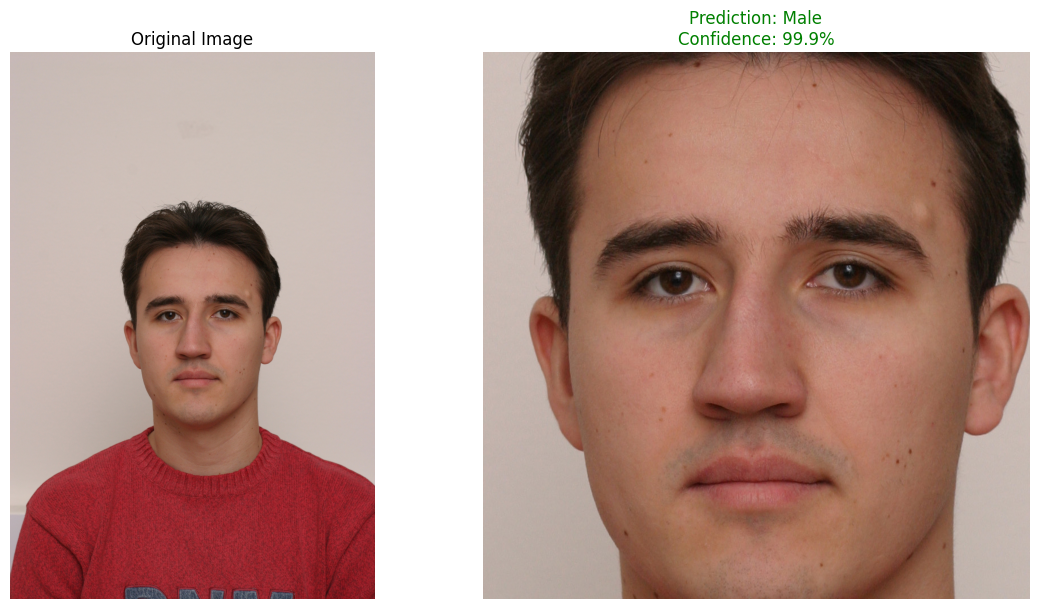

Final Prediction: Male (Confidence: 99.86%)


In [16]:
# =============================================
# ENHANCED PREDICTION FUNCTION WITH VISUALIZATION
# =============================================
def predict_and_show(image_path, model_path='best_model.pth'):
    """Predict gender from any image file and display results visually"""
    # Load model
    model = HybridCNNViT().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Load original image
    try:
        original_img = Image.open(image_path).convert('RGB')
    except:
        raise ValueError(f"Could not load image from {image_path}")
    
    # Preprocess with face cropping
    cropped_img = face_crop(original_img)
    
    # Apply transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(cropped_img).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(prob, 1)
    
    # Get prediction result
    gender = "Male" if predicted.item() == 1 else "Female"
    confidence_percent = confidence.item() * 100
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Processed Image with Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(cropped_img)
    prediction_text = f"Prediction: {gender}\nConfidence: {confidence_percent:.1f}%"
    plt.title(prediction_text, color='green' if confidence_percent > 75 else 'orange')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return gender, confidence.item()

# Example usage1:
gender, confidence = predict_and_show("/kaggle/input/hackathon-dataset-new/Comys_Hackathon5/Task_A/val/male/009_frontal.jpg")
print(f"Final Prediction: {gender} (Confidence: {confidence:.2%})")

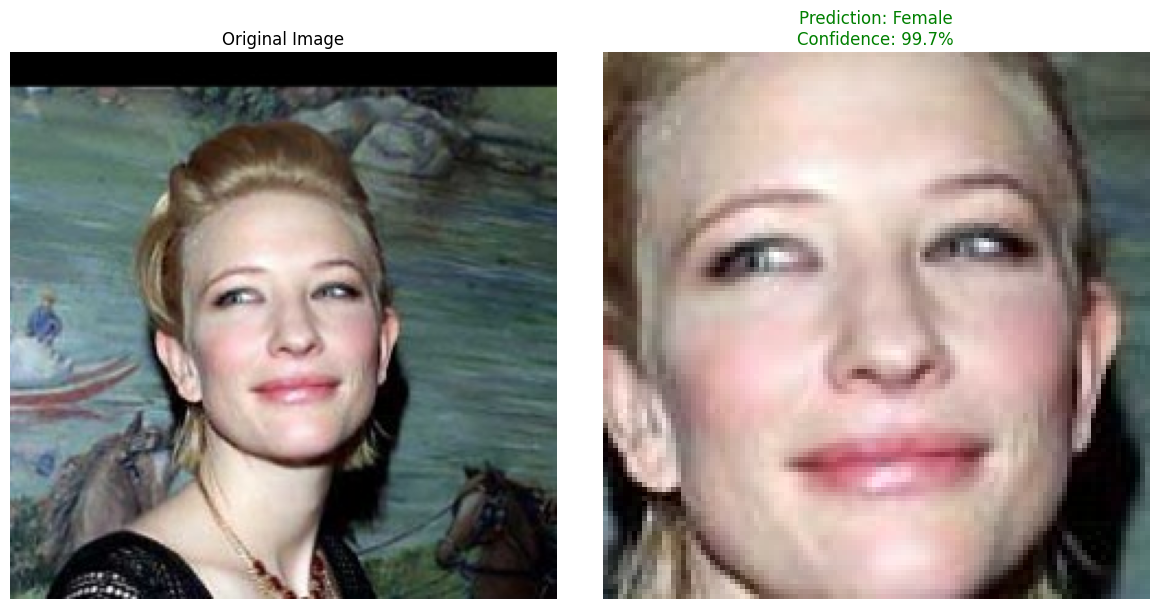

Final Prediction: Female (Confidence: 99.65%)


In [19]:
# Example usage2:
gender, confidence = predict_and_show("/kaggle/input/hackathon-dataset-new/Comys_Hackathon5/Task_A/val/female/Cate_Blanchett_0001.jpg")
print(f"Final Prediction: {gender} (Confidence: {confidence:.2%})")

Evaluating Validation Set: 100%|██████████| 14/14 [00:17<00:00,  1.25s/it]



Model Evaluation Metrics:
Accuracy: 0.9455
Precision: 0.9401
Recall: 0.9905
F1-Score: 0.9647



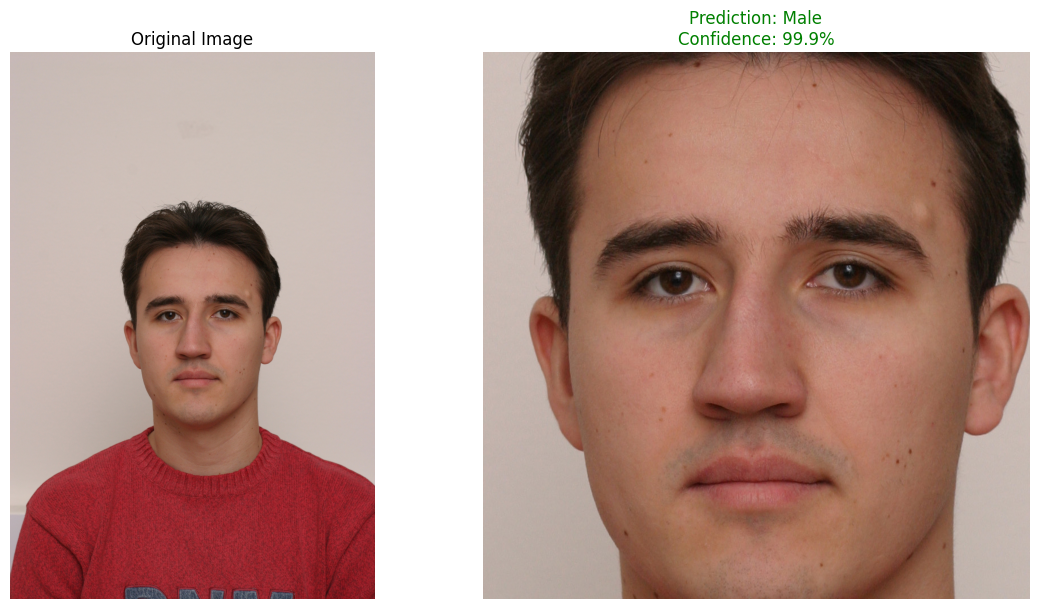

In [28]:
''' Enhanced prediction function that returns both the prediction results and evaluation metrics, 
    along with visualizations '''

def evaluate_and_predict(image_path=None, model_path='best_model.pth', val_loader=None):
    
    # Load model
    model = HybridCNNViT().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    # Validation metrics calculation
    if val_loader is not None:
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Evaluating Validation Set"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
        precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
        
        print("\n" + "="*50)
        print("Model Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print("="*50 + "\n")
    
    # Single image prediction
    if image_path is not None:
        try:
            original_img = Image.open(image_path).convert('RGB')
        except:
            raise ValueError(f"Could not load image from {image_path}")
        
        cropped_img = face_crop(original_img)
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        img_tensor = transform(cropped_img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(img_tensor)
            prob = torch.softmax(output, dim=1)
            confidence, predicted = torch.max(prob, 1)
        
        gender = "Male" if predicted.item() == 1 else "Female"
        confidence_pct = confidence.item() * 100
        
        # Visualization
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title("Original Image")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cropped_img)
        plt.title(f"Prediction: {gender}\nConfidence: {confidence_pct:.1f}%", 
                 color='green' if confidence_pct > 75 else 'orange')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return gender, confidence.item()
    
    return None

# Usage examples:
# 1. Get metrics only:
# evaluate_and_predict(val_loader=dataloaders['val'])

# 2. Get prediction only (returns tuple, shows image):
# gender, confidence = evaluate_and_predict(image_path="test.jpg")

# 3. Get both (prints metrics and returns prediction):
gender, confidence = evaluate_and_predict(
    image_path="/kaggle/input/hackathon-dataset-new/Comys_Hackathon5/Task_A/val/male/009_frontal.jpg",
    val_loader=dataloaders['val']
)